# Creating the Model Grid

In this notebook, we will explore how to create the grid of our "heat wave blob" model. This will be based off of the demonstration for Mike's example model in the California current. Lets go ahead and make our model Grid!
First, import packages to re-create and visualize the model grid here:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

## Blake's Model

The grid for Blakes's model will be located on the west coast of California covering 160-110$^{\circ}$W in longitude and 25-60$^{\circ}$N in latitude. The grid spacing will be $1/12^{\circ}$ in the zonal (east-west) direction and $1/16^{\circ}$ in the meridional (north-south) direction, covering a grid of 360 rows and 240 columns. (ASK MIKE WHAT WOULD BE A GOOD GRID Dimension)

In the data file for my model, I will specifiy the following parameters in the `PARM04` namelist in the `data` file:

This grid can be recreated in Python as follows:

In [27]:
# define the parameters that will be used in the data file

#steps:
# 1. find xc yc of the model
# 2. figure out the number of rowsand columns
delX = 1/12     # they are different because the increment of degrees are not the same when transversing longitude vs latitude
delY = 1/16     # upper bounds
xgOrigin = -160 # matching domain for the lower bound of the model
ygOrigin = 25   # matching the domain for the upper bound of our new updated model
n_rows = 630 # try to get the mximum number of prime factors here! You want to increase nPX and nPy almost to the max (increase speed of processing model to be able to use more processors.)
n_cols = 540 # to high of a npx and npy will have the exchange of data diminish the efficiency of 

# good rule for file size, would be ~ 30x30


# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX) #(lower, upper, step)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY) #(lower, upper, step)
XC, YC = np.meshgrid(xc, yc)
print(np.size((XC)))

340830


### its important to make your model grid, make sure your numbers (like 240 and 360) have many divisors <structure of SIZE.h file depends on the ability to be slip up with computing clusters, so more prime factors allow more dividing for processors even so make sure they have alot of prime factorization>

NPX = 5 means divided amonst 5 processors

In [28]:
np.arange(1,5)

array([1, 2, 3, 4])

### Visualizing the Grid
The grids above can be visualized as follows:

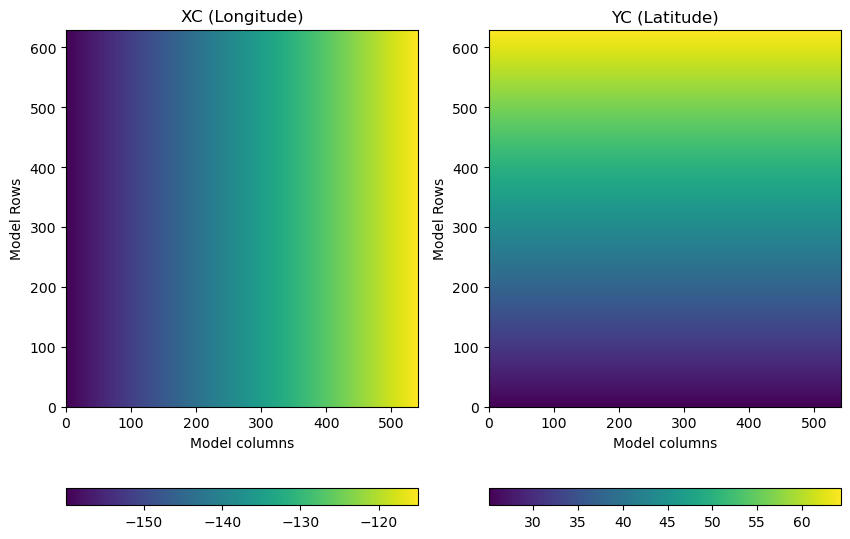

In [29]:
# make a plot of XC and YC
# these are the longitude and latitude of the graph
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('XC (Longitude)')
plt.ylabel('Model Rows')
plt.xlabel('Model columns')




plt.subplot(1,2,2)
C = plt.pcolormesh(YC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('YC (Latitude)')
plt.ylabel('Model Rows')
plt.xlabel('Model columns')


plt.show()

### Visualizing the Grid on a Map with Cartopy
To get a sense of where the model is located on the globe, cartopy can be be used to plot the domain on the globe:

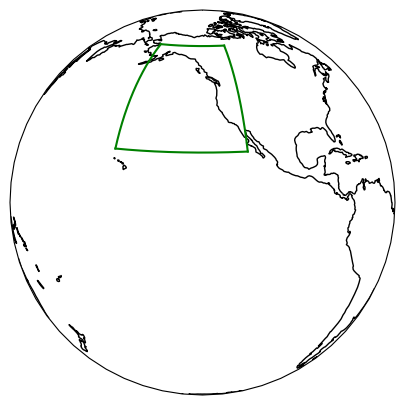

In [31]:
# plot method
plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.Orthographic(-130,10))
ax.plot(XC[:,0], YC[:,0], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[:,-1], YC[:,-1], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[0,:], YC[0,:], 'g-', transform=ccrs.PlateCarree())
ax.plot(XC[-1,:], YC[-1,:], 'g-', transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
plt.show()
# make sure to plot the gride on globe to make sure your capturing right area (we are capturing the area that has the HOT BLOB in it)
#in general if you construct model and put some of your grid of land will save a boundary is safe as it will help you alot

# another important factor is GRID SPACING (larger spacing) means the degrees so you want xc and yc to be about the same (for this we have our grid spacing
# doubled as compared to mikes model as we want to be able to capture the whole west coast portion that would have data to visualize the hot blob of 2015

### Visualizing the Grid Spacing
The model grid is defined in terms of units in longitude and latitude although it is useful to quantify the grid spacing in terms of more familiar units, such as meters. The following `great_circle_distance` function can be used to quantify this distance:

In [32]:
# functions returns the pairs distance between latitude and longitude
def great_circle_distance(lon_ref, lat_ref, Lon, Lat):
    earth_radius = 6371000
    lon_ref_radians = np.radians(lon_ref)
    lat_ref_radians = np.radians(lat_ref)
    lons_radians = np.radians(Lon)
    lats_radians = np.radians(Lat)
    lat_diff = lats_radians - lat_ref_radians
    lon_diff = lons_radians - lon_ref_radians
    d = np.sin(lat_diff * 0.5) ** 2 + np.cos(lat_ref_radians) * np.cos(lats_radians) * np.sin(lon_diff * 0.5) ** 2
    h = 2 * earth_radius * np.arcsin(np.sqrt(d))
    return(h)

Then, loop through the points to generate inter-point distances in the horizontal (`dXC`) and vertical (`dYC`) directions:

In [33]:
dXC = np.zeros((np.shape(XC)[0], np.shape(XC)[1]-1))
for row in range(np.shape(XC)[0]):
    for col in range(np.shape(XC)[1]-1):
        dXC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row,col+1], YC[row,col+1])

dYC = np.zeros((np.shape(YC)[0]-1, np.shape(YC)[1]))
for row in range(np.shape(XC)[0]-1):
    for col in range(np.shape(XC)[1]):
        dYC[row,col] = great_circle_distance(XC[row,col], YC[row,col], XC[row+1,col], YC[row+1,col])

Finally, make a plot of the inter-point distances:

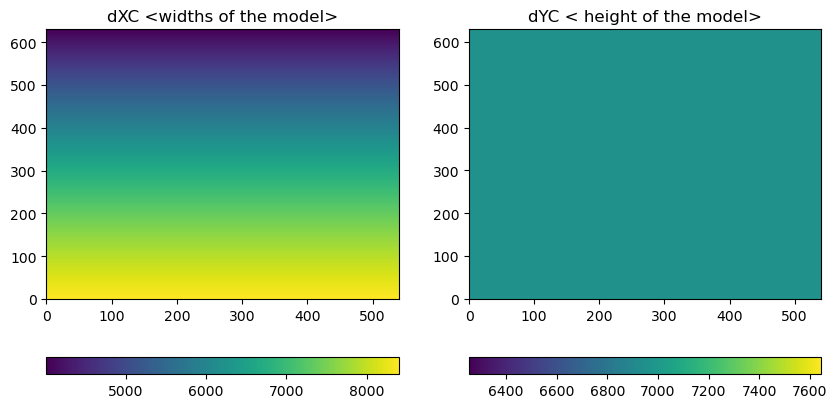

In [34]:
# make a plot of XC and YC
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(dXC)
plt.colorbar(C, orientation = 'horizontal')
plt.title('dXC <widths of the model>')

plt.subplot(1,2,2)
C = plt.pcolormesh(dYC.round(3))
plt.colorbar(C, orientation = 'horizontal')
plt.title('dYC < height of the model>')

plt.show()

As we can see the grid has a resolution of about 8 km, although there is a north-south gradient in horizontal distances (in other words, points further north are closer together). 